In [136]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
train = pd.read_csv("human-activity-recognition-with-smartphones/train.csv")
test = pd.read_csv("human-activity-recognition-with-smartphones/test.csv")

In [24]:
import pandas as pd

# Combine DataFrames along rows (axis=0)
combined_df = pd.concat([train, test], ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('human-activity-recognition-with-smartphones.csv', index=False)


In [138]:
print('Number of duplicates in train : ',sum(train.duplicated()))
print('Number of duplicates in test : ', sum(test.duplicated()))

Number of duplicates in train :  0
Number of duplicates in test :  0


In [139]:
print('Total number of missing values in train : ', train.isna().values.sum())
print('Total number of missing values in train : ', test.isna().values.sum())

Total number of missing values in train :  0
Total number of missing values in train :  0


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400'),
  Text(1600.0, 0, '1600')])

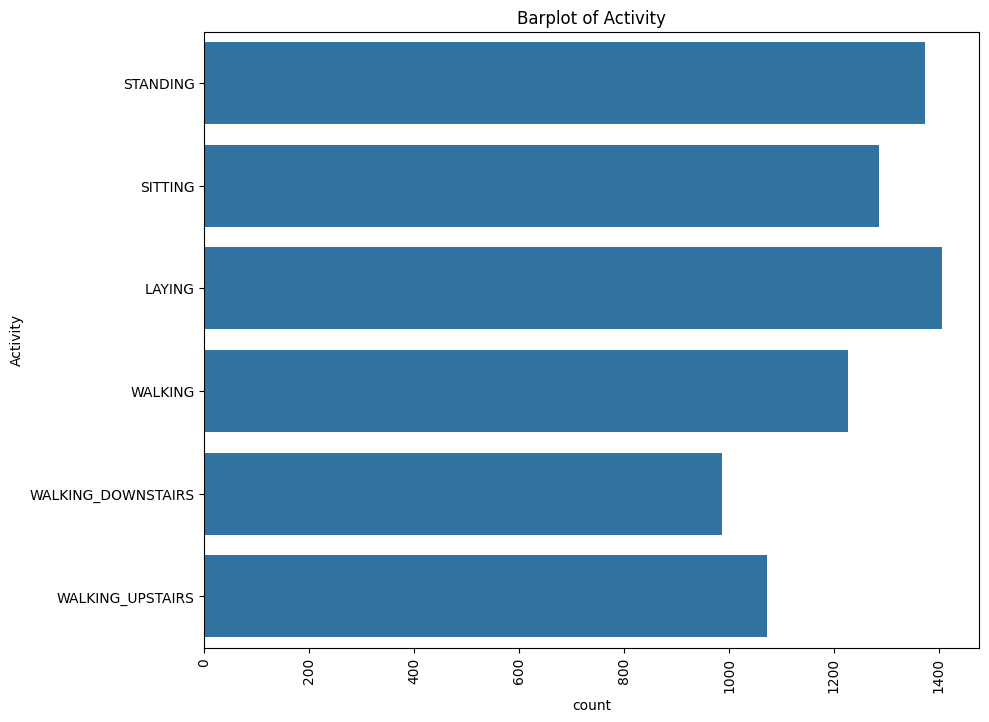

In [140]:
plt.figure(figsize=(10,8))
plt.title('Barplot of Activity')
sns.countplot(train.Activity)
plt.xticks(rotation=90)

In [141]:
# train = train[train['Activity'] != 'WALKING_DOWNSTAIRS']
# train = train[train['Activity'] != 'WALKING_UPSTAIRS']
train = train[~train['Activity'].isin(['WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]



In [145]:
train.Activity.value_counts()

Activity
LAYING      1407
STANDING    1374
SITTING     1286
WALKING     1226
Name: count, dtype: int64

In [146]:
test = test[test['Activity'] != 'WALKING_DOWNSTAIRS']
test = test[test['Activity'] != 'WALKING_UPSTAIRS']


In [147]:
test.Activity.value_counts()

Activity
LAYING      537
STANDING    532
WALKING     496
SITTING     491
Name: count, dtype: int64

In [148]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Activity'] = le.fit_transform(train.Activity)
test['Activity'] = le.fit_transform(test.Activity)
train['Activity'].sample(5)

5750    0
5803    3
896     0
1015    2
7004    1
Name: Activity, dtype: int32

In [149]:
original_labels = le.inverse_transform([0,1,2,3])      # Only to know which one corresponds to each number

In [150]:
y_train = train.Activity
X_train = train.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['subject', 'Activity'], axis=1)
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)

Training data size :  (5293, 561)
Test data size :  (2056, 561)


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [167]:
parameters = {'C':np.arange(10,61,10), 'penalty':['l2','l1'], 'multi_class': ['ovr']}
lr_classifier = LogisticRegression()
lr_classifier_rs = RandomizedSearchCV(lr_classifier, param_distributions=parameters, cv=5,random_state = 42)
lr_classifier_rs.fit(X_train, y_train)
y_pred = lr_classifier_rs.predict(X_test)

In [168]:
lr_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Logistic Regression : ", lr_accuracy)

Accuracy using Logistic Regression :  0.9674124513618677


In [169]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,lables):
    labels  = original_labels[lables] 
    fig, ax = plt.subplots(figsize=(12,8)) # for plotting confusion matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=labels, yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label')
    plt.xticks(rotation = 90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [170]:
np.unique(y_pred)
original_labels
selected_labels = original_labels[np.unique(y_pred)]
selected_labels


array(['LAYING', 'SITTING', 'STANDING', 'WALKING'], dtype=object)

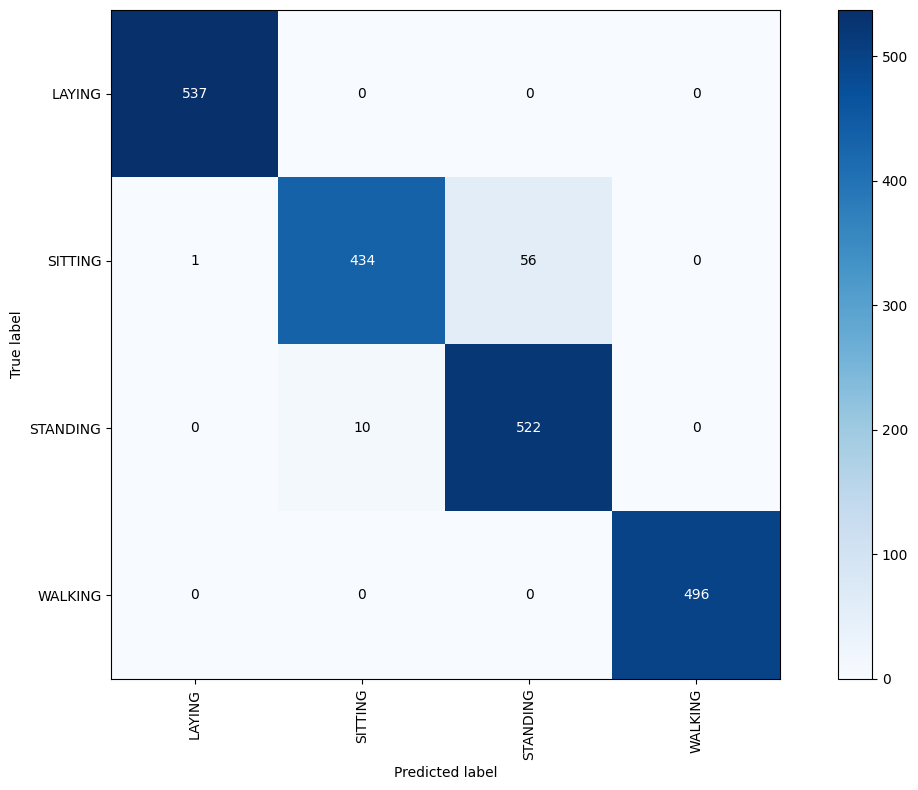

In [171]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred))  # plotting confusion matrix

In [172]:
y_pred

array([2, 2, 2, ..., 3, 3, 3])

In [173]:
X_test.iloc[[0]]
X_test.count()

tBodyAcc-mean()-X                       2056
tBodyAcc-mean()-Y                       2056
tBodyAcc-mean()-Z                       2056
tBodyAcc-std()-X                        2056
tBodyAcc-std()-Y                        2056
                                        ... 
angle(tBodyGyroMean,gravityMean)        2056
angle(tBodyGyroJerkMean,gravityMean)    2056
angle(X,gravityMean)                    2056
angle(Y,gravityMean)                    2056
angle(Z,gravityMean)                    2056
Length: 561, dtype: int64

In [174]:
import json
# output_class = lr_classifier_rs.predict(X_test.iloc[0:2])
output_class = lr_classifier_rs.predict(X_test.iloc[[2055]])
output_class_label = original_labels[output_class] 
# Convert the array to a list and then to JSON
activity_json = json.dumps(output_class_label.tolist())
print(activity_json)

["WALKING"]


In [178]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

Y_scores = lr_classifier_rs.predict_proba(X_test)
#print(Y_scores)
auc = roc_auc_score(y_test, Y_scores, multi_class='ovr')
print('AUC: %.3f' % auc)


AUC: 0.992
